In [252]:
import skrf as rf
import matplotlib.pyplot as plt
from scipy import constants
from scipy.interpolate import interp1d
import numpy as np
from scipy.signal import convolve
import matplotlib.pyplot as plt

In [342]:
network=rf.Network('../../Experiments_uncoatedsensor/NanoVNAV2/uncoated_air.s1p')
S11=network.s[:,0,0]
cable_v=0.66
speed_of_light = 299792458.0
npts=network.frequency.npoints
M = 2 * (npts-1)
deltafreq = network.frequency.stop - network.frequency.start 

In [343]:
rangetime = 1/deltafreq
# DeltaTime=RangeTime/(M-1);
deltatime = rangetime/(M-1)
# taxis=(0:DeltaTime:RangeTime);
taxis = np.linspace(0, rangetime, M)
daxis = speed_of_light/2.0*cable_v*taxis


In [344]:
v1 = np.zeros(M)
# v1(1)=1;
v1[0] =1
# % su transformada
# f1=fft(v1);
f1 = np.fft.fft(v1)
# fftPasada por una ventana Hamming para eliminar sobreoscilaciones
#f1=f1.*fftshift(hamming1(M));
f1 = f1 * np.fft.fftshift(np.hamming(M))

In [345]:
respfreq = np.concatenate((f1[0:int(M/2)]*S11[0:int(M/2)], f1[(int(M/2)):M]*np.conj(np.fliplr([S11[1:(int(M/2)+1)]])[0])))

# % Transformada inversa para pasar al dominio del tiempo

# v2=ifft(respfreq);
v2 = np.fft.ifft(respfreq)

# % Integramos para respuesta al escalon

#pp=np.cumsum(np.real(v2));
rho = np.real(v2).cumsum()

# Adjust for cable effects (optional)
#threshold = 0.2  # Define a suitable threshold
#rho[:np.argmax(np.abs(rho) > threshold)] = 0

rho /= np.max(np.abs(rho))

In [346]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import isnan

class Todoroff:
    def __init__(self,file):
        self.file=file
    def import_csv(self):
        if (not self.file.endswith('.csv')):
            file = self.file + ".csv"
        else:
            file = self.file
        df = pd.read_csv(file,skiprows=0)
        #df=df.drop([0,1])
        unique_timestamps=df["TIMESTAMP"].nunique()
        if unique_timestamps ==1:
            timestamp = df.loc[2]["TIMESTAMP"]
            date, time = timestamp.split(" ")
            Vp=df.loc[2]["Vp"]
            WaveAvg=df.loc[2]["Averages"]
            points=df.loc[2]["Points"]
            cablelen=df.loc[2]["CableLen"]
            windowlen=df.loc[2]["WindowLen"]
            probelen=df.loc[2]["ProbeLen"]
            Vp=float(Vp)
            points=int(points)
            windowlen=int(windowlen)
            probelen=float(probelen)
            measurements = df.loc[2]["Waveform(1)":] # extract measurements from Waveform 1 row
            measurements = measurements.astype(float)  # convert to float type
            measurements = measurements[~isnan(measurements)]  # filter out NaN values
            measurements.iloc[0]=0 #setting the beginning of the trace to zero
        else:
            timestamp = df["TIMESTAMP"]
            Vp=df["Vp"]
            WaveAvg=df["AverageCnt"]
            points=df["PointsCnt"]
            cablelen=df["CableLen"]
            windowlen=df["WindowLen"]
            probelen=df["ProbeLen"]
            Vp=Vp.astype(float)
            points=points.astype(int)
            windowlen=windowlen.astype(int)
            probelen=probelen.astype(float)
            selected_columns=[]
            for i in range(1,points.loc[2]+1):
                selected_columns.append(f"Waveform({i})")
            measurements=df[selected_columns].copy()
            measurements = measurements.astype(float)  # convert to float type
            measurements = measurements[~isnan(measurements)]  # filter out NaN values
            measurements["Waveform(1)"]=0
        return timestamp, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements
    
    def impulse_response(self):
        timestamp, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements=self.import_csv()
        self.LightSpeed=3*(10**8)
        #Vp=Vp.astype(float)
        #points=points.astype(int)
        #windowlen=windowlen.astype(float)
        num_rows = points.shape[0]
        for idx in points.index:
            num_points=points.loc[idx]
            WaveformApparentDistance=np.zeros((num_rows,num_points))
            WaveformResponseTime=np.zeros((num_rows,num_points))
            ImpulseResponse=np.zeros((num_rows,num_points))
            Reflectedsignal=measurements.values
            VDown = [np.zeros((num_points, num_points)) for _ in range(num_rows)]
            for j in range(num_rows):
                WaveformApparentDistance[j,0]=0
                ImpulseResponse[j,0]=0
                for i in range(1, num_points):
                    WaveformApparentDistance[j,i] = WaveformApparentDistance[j,i - 1] + (windowlen.loc[idx] / (points.loc[idx] - 1))
                    WaveformResponseTime[j,i] = (2 * WaveformApparentDistance[j,i] / (self.LightSpeed * Vp.loc[idx]))*1000000000
                for i in range(0, num_points):
                    Reflectedsignal[j,i]=Reflectedsignal[j,i]-1
                for i in range(1, num_points-1):
                    ImpulseResponse[j,i] = Reflectedsignal[j,i+1]-Reflectedsignal[j,i]
                for i in range(0, num_points):
                    VDown[j][i, 0] = ImpulseResponse[j,i]
                    
        return WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown

    def Selectstartendprobe(self):
        timestamp, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements=self.import_csv()
        WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown=self.impulse_response()
        num_rows = points.shape[0]
        for idx in points.index:
            num_points=points.loc[idx]
            Segments=np.zeros((num_rows, num_points))
            dy_dt=np.zeros((num_rows,num_points))
            dy_dt2=np.zeros((num_rows,num_points))
            dy_dt_alt=np.zeros((num_rows,num_points))
            measur=measurements.values
            #points=points.astype(int)
            for j in range(num_rows):
                Segments[j]=np.arange(1,num_points+1)
                for i in range(0, len(WaveformResponseTime[j])-1):
                    dy_dt[j,i]=((measur[j,i+1]-measur[j,i])/(WaveformResponseTime[j,i+1]-WaveformResponseTime[j,i]))
                dy_dt[j,num_points-1]=-measur[j,num_points-1]/-WaveformResponseTime[j,num_points-1]
                for i in range(0, len(WaveformResponseTime[j])-1):
                    dy_dt2=(dy_dt[j,i+1]-dy_dt[j,i])/(WaveformResponseTime[j,i+1]-WaveformResponseTime[j,i])
                #dy_dt2[j,num_points-1]=-dy_dt[j,num_points-1]/-WaveformResponseTime[j,num_points-1]
                for i in range(0, len(WaveformResponseTime[j])-2):
                    dy_dt_alt[j,i]=(measur[j,i+2]-measur[j,i])/(WaveformResponseTime[j,i+2]-WaveformResponseTime[j,i])
                #dy_dt_alt[j,num_points-2]=(-measurements[j,points-1]/-WaveformResponseTime[j,points-1])
        peak_indices = []
        # Iterate over each array dy_dt[j]
        for j in range(len(dy_dt)):
            # Get the indices of the 20 highest peaks in dy_dt[j]
            indices = sorted(range(len(dy_dt[j])), key=dy_dt[j].__getitem__, reverse=True)[:20]
            peak_indices.append(indices)
      
        return Segments,dy_dt, dy_dt2, dy_dt_alt, peak_indices
            
    def forwardmodel(self):
        timestamp, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements=self.import_csv()
        WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown=self.impulse_response()
        #points=points.astype(int)
        num_rows = points.shape[0]
        for idx in points.index:
            num_points=points.loc[idx]
            Vup = [np.zeros((num_points, num_points)) for _ in range(num_rows)]
            Segmentreflcoef=[np.zeros((1,num_points)) for _ in range(num_rows)]
        for x in range(num_rows):
            Vup[x][0,0]=1
            Segmentreflcoef[x][0,0]=VDown[x][1,0]/Vup[x][0,0]
            Vup[x][0,1]=Vup[x][0,0]*(1+Segmentreflcoef[x][0,0])
            for j in range(1, num_points-1):
                VDown[x][j,1]=VDown[x][j+1,0]/(1-Segmentreflcoef[x][0,0])
                Vup[x][j,1]=-VDown[x][j,1]*Segmentreflcoef[x][0,0]
            Segmentreflcoef[x][0,1]=VDown[x][1,1]/Vup[x][0,1]
            Vup[x][0,2]= Vup[x][0,1]*(1+Segmentreflcoef[x][0,1])
            
            for i in range(2, num_points-1):
                for j in range(1, num_points-i):
                    VDown[x][j,i]= (VDown[x][j+1, i-1] - Segmentreflcoef[x][0, i-1]*Vup[x][j,i-1])/ (1-Segmentreflcoef[x][0,i-1])
                    Vup[x][i,j]= (1+Segmentreflcoef[x][0,i-1])*Vup[x][j,i-1] - Segmentreflcoef[x][0,i-1]*VDown[x][j,i]
                Segmentreflcoef[x][0,i]=VDown[x][1,i]/Vup[x][0,i]
                Vup[x][0,i+1]=Vup[x][0,i]*(1+Segmentreflcoef[x][0,i])

            original_values = np.cumsum(Segmentreflcoef[x])

        return Segmentreflcoef, original_values, VDown, Vup
    
    def inversemodel(self, idxfirst, idxsec, ProbeairImp):
        """
        idxfirst: The index of the first peak (start of the probe)
        idsxsec: The index of the second peak (end of the probe)
        ProbeairImp: Impendance of the probe in the air

        """
        timestamp, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements=self.import_csv()
        WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown=self.impulse_response()
        Segmentreflcoef, original_values, VDown, Vup=self.forwardmodel()
        ProbeairImp=140
        num_rows = points.shape[0]
        Ka_all=[]
        lenact_all=[]
        for idx in points.index:
            num_points=points.loc[idx]
            Impendance=[np.zeros((1,num_points)) for _ in range(num_rows)]
            DielectricConstant=np.zeros((num_rows,num_points))
            Actuallength=np.zeros((num_rows,num_points))
            length=np.zeros((num_rows,num_points))
            for j in range(num_rows):
                Traveltime=(WaveformResponseTime[j,2]-WaveformResponseTime[j,1])/1000000000
                Impendance[j][0,0]=50
                for i in range(1, num_points):
                    Impendance[j][0,i]=Impendance[j][0,i-1]*((1+Segmentreflcoef[j][0,i-1])/(1-Segmentreflcoef[j][0,i-1]))
                for i in range(idxfirst,idxsec+1):
                    DielectricConstant[j,i]=(ProbeairImp/Impendance[j][0,i])**2
                    Actuallength[j,i]=(Traveltime*self.LightSpeed)/(2*(DielectricConstant[j,i]**0.5))
                length[j,0]=Actuallength[j,0]
                for i in range(1,len(Actuallength[j])-1):
                    length[j,i]=Actuallength[j,i]+length[j,i-1]

        for j in range(num_rows):
            lenact=length[j][idxfirst-1:idxsec+1]
            Ka=DielectricConstant[j][idxfirst-1:idxsec+1]
            lenact_all.append(lenact)
            Ka_all.append(Ka)

        lenact_all = np.array(lenact_all)
        Ka_all = np.array(Ka_all)
        return Impendance, Ka_all, lenact_all
    def calibratewatercontent(self, ):
        return
    
    def watercontentcomp(self, idxfirst, idxsec, model='Topp', Topp_params=None, sample_depths=None, porosity=None, bulk_density=None, esoil=None):
        """

        model: string, 
        1.Topp
        2. Modified Topp
        3. Roth (1990)
        4. Modified Roth
        5. Malicki (1996)
        6. Modified Malicki (1996)

        """
        Impendance, Ka, lenact=self.inversemodel(idxfirst, idxsec)
        thetatop=np.zeros(len(Ka))
        thetaroth=np.zeros(len(Ka))
        thetamalicki=np.zeros(len(Ka))
        if model=="Topp":
            for i in range(0, len(Ka)):
                thetatop[i]=((-5.3*(10**(-2)))+(2.92*(10**(-2))*Ka[i])+(-5.5*(10**(-4))*(Ka[i]**2))+(4.3*(10**(-6))*(Ka[i]**3)))
        if model=="Roth":
            for i in range(0, len(Ka)):
                for j in range(len(sample_depths)):
                    if lenact[i] <= sample_depths[j]:
                        # Find the appropriate porosity value corresponding to the depth of the segment
                        current_porosity = porosity[j]
                        # Update thetaroth[i] using the current porosity value
                        thetaroth[i] = (Ka[i]**0.5 - (1 + current_porosity) * (5**0.5) - current_porosity * (1**0.5)) / (80**0.5 - 1**0.5)
                        break  # Exit the inner loop once the appropriate porosity is found
        if model=="Malicki":
            for i in range(0, len(Ka)):
                for j in range(len(sample_depths)):
                    if lenact[i] <= sample_depths[j]:
                        # Find the appropriate bulk density value corresponding to the depth of the segment
                        current_bulkdensity = bulk_density[j]
                        # Update thetamalicki[i] using the current porosity value
                        thetamalicki[i] = ((Ka[i]-0.819-0.168*current_bulkdensity-0.159*(current_bulkdensity)**2)**0.5)/(7.17+1.18*current_bulkdensity)
                        break  # Exit the inner loop once the appropriate bulk density is found
        return thetatop, thetaroth, thetamalicki, lenact



class TodoroffPlotter:
    def __init__(self, td):
        self.td = td

    def plot_reflcoefappdist(self):
       # Call the impulse_response method of the Todoroff instance
       timestamp, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements = self.td.import_csv()
       WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown= self.td.impulse_response()
       # Plotting
       num_rows = points.shape[0]
       if num_rows>10:
           num_subplots=num_rows//10
           rows_sub=num_rows//num_subplots
           fig, axs=plt.subplots(num_subplots, figsize=(10,10))
           for i, ax in enumerate(axs):
               for idx in points.index:
                   for j in range(num_rows):
                       start_idx=j* rows_sub
                       end_idx=start_idx +rows_sub
                       ax.plot(WaveformApparentDistance[start_idx:end_idx], measurements.loc[start_idx+2:end_idx+2], label=f'{timestamp[idx]}')
                       ax.set_xlabel('Distance (m)')
                       ax.set_ylabel('Reflection Coefficient')
                       ax.set_title(f'Reflection Coefficient - Apparent Distance {td.file} {i+1}')
                       ax.set_grid(True)
                       ax.set_legend()
        

    def plot_reflcoeftime(self):
       # Call the impulse_response method of the Todoroff instance
       timestamp, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements = self.td.import_csv()
       WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown= self.td.impulse_response()
       # Plotting
       plt.figure(figsize=(10, 6))
       plt.plot(WaveformResponseTime, measurements, label=f'{timestamp}')
       plt.xlabel('Time (ns)')
       plt.ylabel('Reflection Coefficient')
       plt.title('Reflection Coefficient - Time')
       plt.legend()
       plt.grid(True)
       plt.show()
    
    def plot_startendprobe(self):
        datetime, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements = self.td.import_csv()
        Segments,dy_dt, dy_dt2, dy_dt_alt, indices=self.td.Selectstartendprobe()
        plt.figure(figsize=(10,6))
        num_rows = points.shape[0]
        for j in range(num_rows):
            num_points=points.loc[j]
            plt.plot(Segments[j][indices[j][0]-20:indices[j][0]+int(num_points/5)], measurements.iloc[j,indices[j][0]-20:indices[j][0]+int(num_points/5)], color="black", label="Reflection Coefficient")
            plt.plot(Segments[j][indices[j][0]-20:indices[j][0]+int(num_points/5)], dy_dt[j][indices[j][0]-20:indices[j][0]+int(num_points/5)], color="purple", label="1st Derivative")
            plt.plot(Segments[j][:1024], measurements.iloc[j], color="black", label="Reflection Coefficient")
            plt.plot(Segments[j], dy_dt[j], color="purple", label="1st Derivative")
        #plt.plot(Segments[indices[0]-20:indices[0]+200], dy_dt2[indices[0]-20:indices[0]+200], color="red", label="2nd Derivative")
        plt.xlabel('Segments (1 : n)')
        plt.ylabel('Reflection Coefficient')
        plt.title('Reflection Coefficient - 1st Derivative')
        plt.legend()
        plt.grid(True)
        plt.show()
        print(f"These are the indices {indices[j]} of the 20 first maximum values of the 1st derivative. Select the first (start of the probe) and second (end of the probe) to insert to the inverse model for water content computation")
    
    def plot_modelvdimpulse(self):
        WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown= self.td.impulse_response()
        Segmentreflcoef, original_values, VDown, Vup=self.td.forwardmodel()
        plt.figure(figsize=(10,6))
        plt.plot(WaveformResponseTime, ImpulseResponse, label="Impulse Response")
        plt.plot(WaveformResponseTime, Segmentreflcoef[0], label="Modeled")
        plt.xlabel('Time (ns)')
        plt.ylabel('Impulse Response vs Model')
        plt.title('Implulse Response vs Model')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_Impendance(self, idxfirst, idxsec):
        WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown= self.td.impulse_response()
        Impendance=self.td.inversemodel(idxfirst,idxsec)
        plt.figure(figsize=(10,6))
        plt.plot(WaveformResponseTime, Impendance[0], label="Impendance")
        plt.xlabel('Time (ns)')
        plt.ylabel('Impendance (Ohms)')
        plt.title('Impendance')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_DielectricConstant(self, idxfirst, idxsec):
        Impendance, Ka, lenact=self.td.inversemodel(idxfirst, idxsec)
        plt.figure(figsize=(10,6))
        plt.plot(Ka, -lenact, label="Dielectric constant")
        plt.xlabel('Dielectric constant')
        plt.ylabel('Depth (m.)')
        plt.title('Dielectric Constant - Depth')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def plot_WaterContent(self, idxfirst, idxsec):
        theta, thetaroth,thetamalicki, lenact=self.td.watercontentcomp(idxfirst, idxsec)
        plt.figure(figsize=(10,6))
        plt.plot(theta, -lenact, label="Water Content ($m^3/m^3$)")
        plt.xlabel('Water Content ($m^3/m^3$)')
        plt.ylabel('Depth (m.)')
        plt.title('Water Content - Depth')
        plt.legend()
        plt.grid(True)
        plt.show()


In [314]:
td=Todoroff("../../../TDR100/Test_0.5sensors/2001.csv")

In [315]:
timestamp, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements=td.import_csv()

In [316]:
points.loc[0]

2048

In [317]:
WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown=td.impulse_response()

In [318]:
measurements.loc[0]

Waveform(1)       0.000000
Waveform(2)       0.010580
Waveform(3)       0.011675
Waveform(4)       0.011675
Waveform(5)       0.010580
                    ...   
Waveform(2044)    0.968282
Waveform(2045)    0.968282
Waveform(2046)    0.969376
Waveform(2047)    0.967187
Waveform(2048)    0.966093
Name: 0, Length: 2048, dtype: float64

In [319]:
WaveformApparentDistance[0]

array([0.00000000e+00, 9.77039570e-03, 1.95407914e-02, ...,
       1.99804592e+01, 1.99902296e+01, 2.00000000e+01])

In [320]:
taxis

array([0.00000000e+00, 2.95604319e-12, 5.91208639e-12, 8.86812958e-12,
       1.18241728e-11, 1.47802160e-11, 1.77362592e-11, 2.06923024e-11,
       2.36483456e-11, 2.66043887e-11, 2.95604319e-11, 3.25164751e-11,
       3.54725183e-11, 3.84285615e-11, 4.13846047e-11, 4.43406479e-11,
       4.72966911e-11, 5.02527343e-11, 5.32087775e-11, 5.61648207e-11,
       5.91208639e-11, 6.20769071e-11, 6.50329503e-11, 6.79889935e-11,
       7.09450367e-11, 7.39010799e-11, 7.68571231e-11, 7.98131662e-11,
       8.27692094e-11, 8.57252526e-11, 8.86812958e-11, 9.16373390e-11,
       9.45933822e-11, 9.75494254e-11, 1.00505469e-10, 1.03461512e-10,
       1.06417555e-10, 1.09373598e-10, 1.12329641e-10, 1.15285685e-10,
       1.18241728e-10, 1.21197771e-10, 1.24153814e-10, 1.27109857e-10,
       1.30065901e-10, 1.33021944e-10, 1.35977987e-10, 1.38934030e-10,
       1.41890073e-10, 1.44846117e-10, 1.47802160e-10, 1.50758203e-10,
       1.53714246e-10, 1.56670289e-10, 1.59626332e-10, 1.62582376e-10,
      

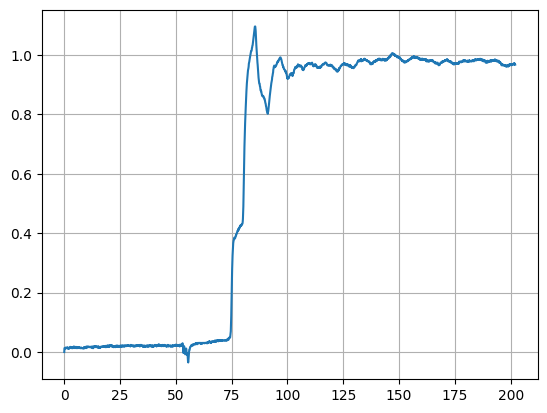

In [340]:
plt.plot(WaveformResponseTime[8], measurements.loc[8])
plt.grid(True)

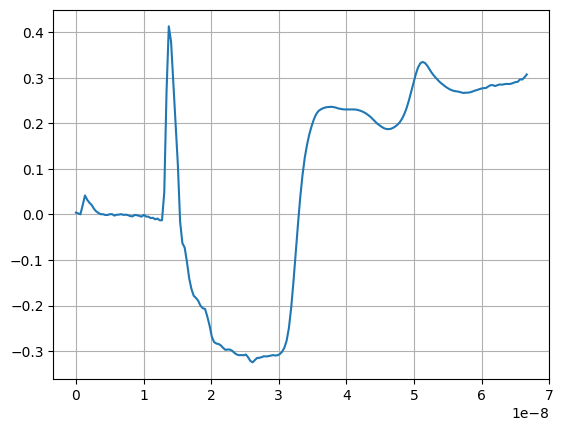

In [339]:
import numpy as np
import pandas as pd

S11 = np.array([0.30773296-0.006141103j, -0.42475632+0.3538512j, 0.81011328-0.094199496j, -0.651433408-0.489114144j, 0.276720032+0.40771936j, -0.346600608+0.480776736j, 0.735612032-0.080348144j, -0.2167428-0.754806016j, 0.007076258+0.15274144j, -0.565896832+0.46066976j, 0.662786816+0.438482464j, 0.400136448-0.571339392j, 0.049057844-0.419282208j, -0.811794688-0.008703372j, 0.021159398+0.831072128j, 0.693664448-0.072668016j, 0.451526656-0.52495264j, -0.559204288-0.57539104j, -0.603310464+0.426578592j, 0.20825312+0.445477376j, 0.640239104+0.034142628j, 0.152705616-0.672740608j, -0.59167296-0.32319408j, -0.511392+0.287633248j, 0.218108192+0.653273984j, 0.67817888-0.178050528j, -0.087189184-0.639705472j, -0.648452096-0.20471632j, -0.393500608+0.555219008j, 0.385260736+0.428342208j, 0.444793312-0.253936496j, -0.159669136-0.507637728j, -0.508262624+0.001042618j, -0.206045888+0.400936032j, 0.240198368+0.367310464j, 0.39284784-0.138716976j, -0.129050224-0.420575744j, -0.461940224+0.073514808j, -0.1453868+0.403556j, 0.19283552+0.301529184j, 0.293795168-0.029077406j, 0.028306662-0.268632672j, -0.296468224-0.159245424j, -0.34050944+0.290384128j, 0.150732864+0.507183264j, 0.54136672+0.071890872j, 0.157314096-0.486401024j, -0.517084352-0.16573336j, -0.306262272+0.531568064j, 0.360779808+0.543140608j, 0.586061888-0.103356768j, -0.024157306-0.550365056j, -0.585050944+0.021111804j, -0.104028608+0.639684992j, 0.579387584+0.348960352j, 0.560326592-0.360600544j, -0.119381888-0.58365184j, -0.50940864+0.068930112j, 0.058948392+0.611620608j, 0.579525376+0.1802532j, 0.366076736-0.375092544j, -0.229889984-0.352365664j, -0.31818144+0.210706768j, 0.186528+0.357553888j, 0.395170976-0.05107682j, 0.102844184-0.322391296j, -0.172818672-0.185919744j, -0.128029512+0.042411004j, 0.055849236+0.039545248j, 0.098452024-0.076728072j, 0.080521344-0.17045752j, -0.013918602-0.2799912j, -0.236312576-0.24177904j, -0.305207072+0.077200064j, 0.040835168+0.225824496j, 0.25295952-0.162314144j, -0.1210622-0.433716768j, -0.448952448-0.141674736j, -0.301795648+0.249902592j, 0.084280248+0.293648224j, 0.320821984-0.108561512j, -0.098479128-0.531333312j, -0.603268864-0.18764264j, -0.40321088+0.360122784j, 0.221697216+0.39018976j, 0.432795392-0.327848352j, -0.328283744-0.55827808j, -0.540378048+0.170419024j, 0.053024088+0.533621248j, 0.551289216+0.079174984j, 0.254306528-0.40202864j, -0.25842184-0.393728064j, -0.444399616+0.200181808j, 0.109103624+0.523243712j, 0.57733504+0.135012736j, 0.367740992-0.477639168j, -0.408959584-0.466580064j, -0.436650112+0.290487648j, 0.210864096+0.598440448j, 0.712999552+0.008633586j, 0.319293248-0.686298816j])

cable_vf = 0.66
speed_of_light = 299792458.0

npts = len(S11)
# M=2*(Npts-1);
M = 2 * (npts-1)
# % Npts=M-1;
# RangeTime=1/DeltaFreq;
deltafreq = 15049500 - 50000

rangetime = 1/deltafreq
# DeltaTime=RangeTime/(M-1);
deltatime = rangetime/(M-1)
# taxis=(0:DeltaTime:RangeTime);
taxis = np.linspace(0, rangetime, M)
daxis = speed_of_light/2.0*cable_vf*taxis
# % excitación tipo impulso ficticio en el dominio temporal
# v1=zeros(1,M);
v1 = np.zeros(M)
# v1(1)=1;
v1[0] =1
# % su transformada
# f1=fft(v1);
f1 = np.fft.fft(v1)
# fftPasada por una ventana Hamming para eliminar sobreoscilaciones
# f1=f1.*fftshift(hamming1(M));
f1 = f1 * np.fft.fftshift(np.hamming(M))

# % Asumimos que la respuesta en frecuencia de nuestro sistema a frecuencias
# % negativas es el complejo conjugado de la que hemos medido a frecuencias
# % positivas

# respfreq=[f1(1:M/2).*S11(1:M/2) f1(M/2+1:M).*conj(fliplr(S11(2:M/2+1)))];
respfreq = np.concatenate((f1[0:int(M/2)]*S11[0:int(M/2)], f1[(int(M/2)):M]*np.conj(np.fliplr([S11[1:(int(M/2)+1)]])[0])))

# % Transformada inversa para pasar al dominio del tiempo

# v2=ifft(respfreq);
v2 = np.fft.ifft(respfreq)

# % Integramos para respuesta al escalon

# pp=cumsum(real(v2));
rho = np.real(v2).cumsum()

plt.plot(taxis,rho)
plt.grid(True)